In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
import gc; gc.enable() # memory is tight

In [2]:
# config
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'

VALID_IMG_COUNT = 1000

MAX_TRAIN_IMAGES = 15000 
BASE_MODEL='RESNET52' 
IMG_SIZE = (299, 299) 
BATCH_SIZE = 128
EPOCHS = 10
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = .001
RGB_FLIP = 1 

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')

In [3]:
# load mask data
masks = pd.read_csv(os.path.join('../input/', 'train_ship_segmentations.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
masks.head()

131030 masks found
104070


,ImageId,EncodedPixels,path
0,00003e153.jpg,NaN,../input\train\00003e153.jpg
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,../input\train\000155de5.jpg
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,../input\train\00021ddc3.jpg
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,../input\train\00021ddc3.jpg
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,../input\train\00021ddc3.jpg


In [4]:
# slplit dataset image with ship and no ship
from sklearn.model_selection import train_test_split
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.3, stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

91709 training masks
39321 validation masks


In [5]:
train_df = train_df.sample(min(MAX_TRAIN_IMAGES, train_df.shape[0]))
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


In [6]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

In [9]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (128, 299, 299, 3) float32 -123.68 151.061
y (128, 1) float64 0.0 1.0


In [10]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

c:\users\cueva\miniconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [11]:
from keras import models, layers
from keras.optimizers import Adam
img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
# img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
pt_features = base_pretrained_model(img_in)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
bn_features = layers.BatchNormalization()(pt_features)
feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
gmp_dr = layers.GlobalMaxPooling2D()(feature_dropout)
dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(gmp_dr))
out_layer = layers.Dense(1, activation = 'sigmoid')(dr_steps)

ship_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

ship_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])

ship_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_RGB_In (InputLayer)    (None, 299, 299, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 10, 10, 2048)      23587712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 2048)      8192      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 10, 10, 2048)      0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('boat_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

c:\users\cueva\miniconda3\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [13]:
train_gen.batch_size = BATCH_SIZE
ship_model.fit_generator(train_gen, 
                      validation_data = (valid_x, valid_y), 
                      epochs = EPOCHS, 
                      callbacks = callbacks_list,
                      workers = 10, steps_per_epoch = 2)

Epoch 1/10
2/2 [==============================] - 39s 19s/step - loss: 6.2899 - binary_accuracy: 0.4883 - val_loss: 6.3501 - val_binary_accuracy: 0.5730

Epoch 00001: val_loss improved from inf to 6.35015, saving model to boat_detector_weights.best.hdf5
Epoch 2/10
2/2 [==============================] - 13s 6s/step - loss: 6.2042 - binary_accuracy: 0.6016 - val_loss: 6.5012 - val_binary_accuracy: 0.5730

Epoch 00002: val_loss did not improve from 6.35015
Epoch 3/10
2/2 [==============================] - 13s 6s/step - loss: 6.6450 - binary_accuracy: 0.5664 - val_loss: 3.6016 - val_binary_accuracy: 0.5880

Epoch 00003: val_loss improved from 6.35015 to 3.60162, saving model to boat_detector_weights.best.hdf5
Epoch 4/10
2/2 [==============================] - 13s 7s/step - loss: 3.7579 - binary_accuracy: 0.6250 - val_loss: 0.5684 - val_binary_accuracy: 0.8080

Epoch 00004: val_loss improved from 3.60162 to 0.56839, saving model to boat_detector_weights.best.hdf5
Epoch 5/10
2/2 [============

In [14]:
ship_model.load_weights(weight_path)
ship_model.save('full_ship_model.h5')

In [15]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
submission_df = pd.read_csv('../input/sample_submission.csv')
submission_df['path'] = submission_df['ImageId'].map(lambda x: os.path.join(test_image_dir, x))

88500 test images found


In [16]:
test_gen = flow_from_dataframe(valid_idg, submission_df, path_col = 'path', y_col = 'ImageId', 
                               target_size = IMG_SIZE, color_mode = 'rgb', batch_size = BATCH_SIZE, 
                               shuffle = False)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 88486 images


c:\users\cueva\miniconda3\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
c:\users\cueva\miniconda3\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
c:\users\cueva\miniconda3\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
c:\users\cueva\miniconda3\lib\site-packages\skimage\util\_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montag

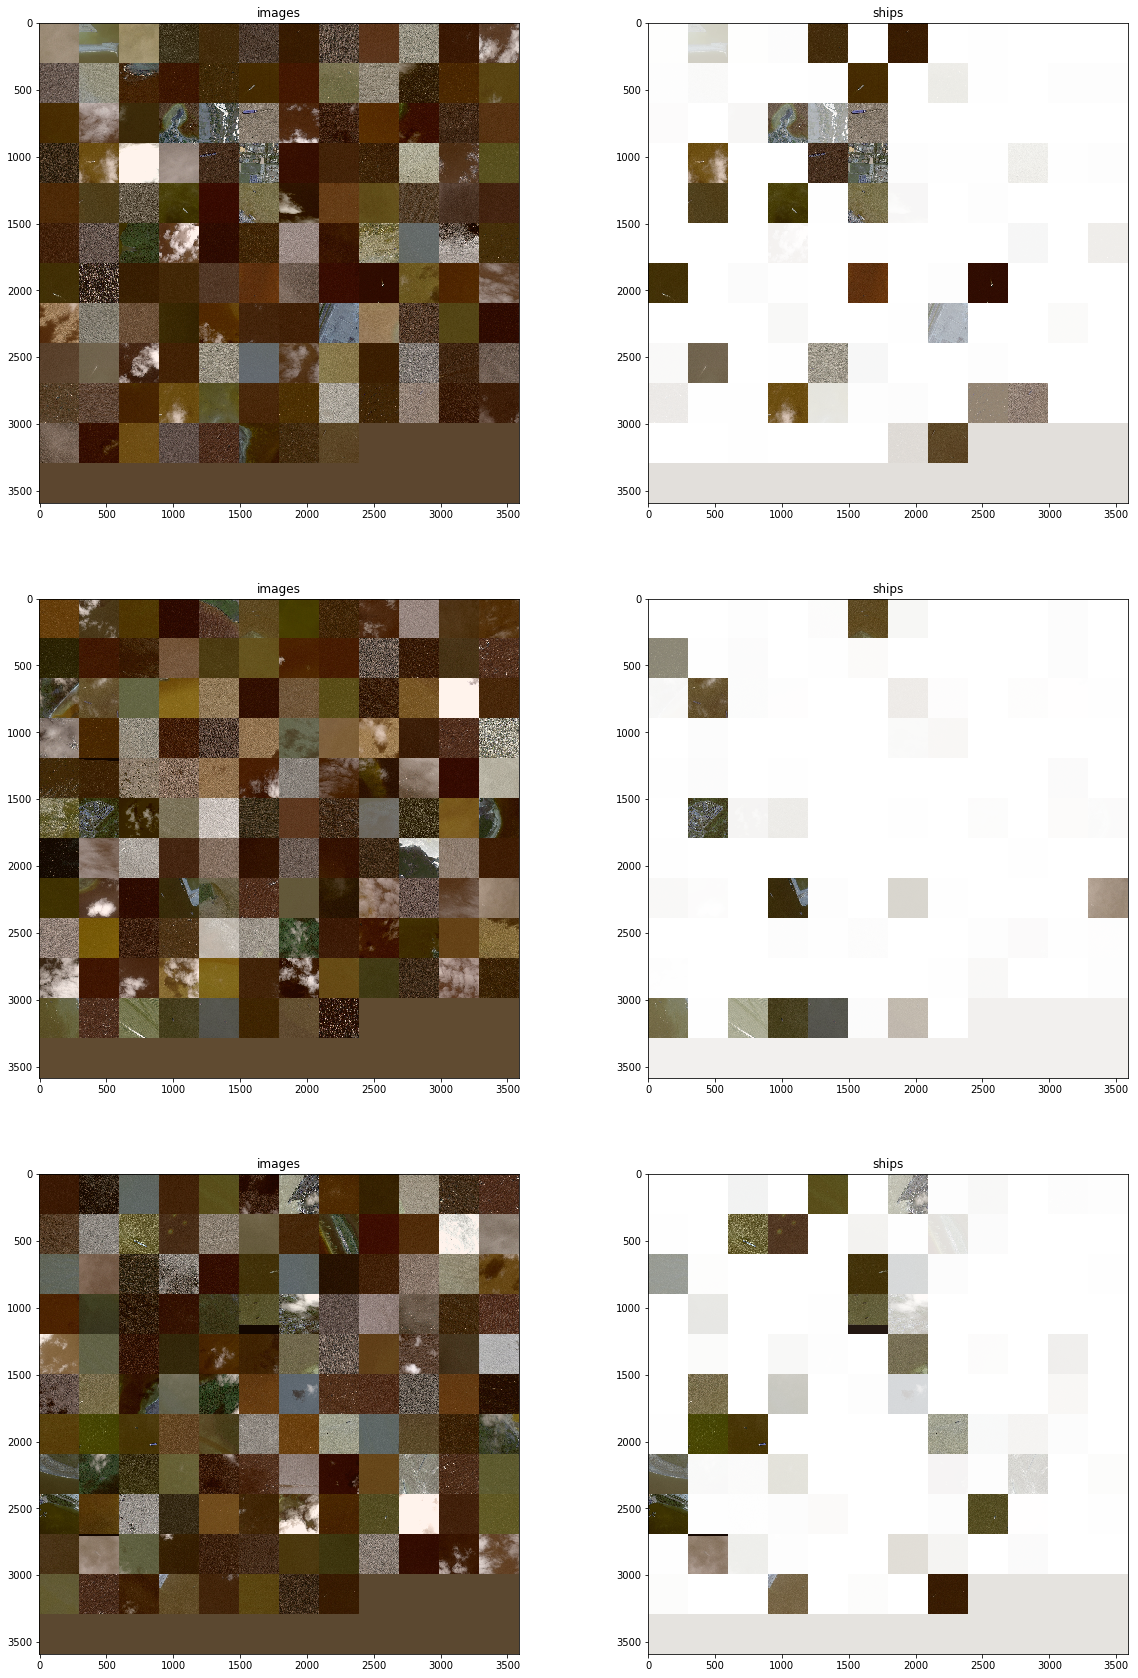

In [17]:
fig, m_axs = plt.subplots(3, 2, figsize = (20, 30))
for (ax1, ax2), (t_x, c_img_names) in zip(m_axs, test_gen):
    t_y = ship_model.predict(t_x)
    t_stack = ((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, :, ::RGB_FLIP]
    ax1.imshow(montage_rgb(t_stack))
    ax1.set_title('images')
    alpha_stack = np.tile(np.expand_dims(np.expand_dims(t_y, -1), -1), [1, t_stack.shape[1], t_stack.shape[2], 1])
    rgba_stack = np.concatenate([t_stack, alpha_stack], -1)
    ax2.imshow(montage_rgb(rgba_stack))
    ax2.set_title('ships')
fig.savefig('test_predictions.png')

In [18]:
BATCH_SIZE = BATCH_SIZE*2 # we can use larger batches for inference
test_gen = flow_from_dataframe(valid_idg, submission_df, path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 88486 images


In [19]:
from tqdm import tqdm_notebook
all_scores = dict()
for _, (t_x, t_names) in zip(tqdm_notebook(range(test_gen.n//BATCH_SIZE+1)),
                            test_gen):
    t_y = ship_model.predict(t_x)[:, 0]
    for c_id, c_score in zip(t_names, t_y):
        all_scores[c_id] = c_score

KeyboardInterrupt: 

In [ ]:
submission_df['score'] = submission_df['ImageId'].map(lambda x: all_scores.get(x, 0))

In [ ]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# empty image
zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [ ]:
submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)

In [ ]:
out_df = submission_df[['ImageId', 'EncodedPixels']]
out_df.to_csv('submission.csv', index=False)
out_df.head(20)